In [53]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

NameError: name 'matplotlib' is not defined

In [4]:
class DistributionAnalyzer:
    """Class to analyze and fit distributions to data using scipy's built-in methods."""
    
    def __init__(self):
        # Define distributions to test
        self.distributions = [
            stats.norm, stats.lognorm, stats.gamma, 
            stats.expon, stats.weibull_min, stats.uniform
        ]
        self.dist_names = [
            'normal', 'lognormal', 'gamma', 
            'exponential', 'weibull', 'uniform'
        ]

    def fit_distributions(self, data: np.ndarray) -> Dict:
        """
        Fit multiple distributions to the data and compute goodness-of-fit metrics.
        
        Args:
            data: Array of observations
            
        Returns:
            Dictionary containing fit results for each distribution
        """
        results = {}
        n = len(data)
        
        for dist, name in zip(self.distributions, self.dist_names):
            try:
                # Fit distribution to data
                params = dist.fit(data)
                
                # Calculate log-likelihood
                logL = np.sum(dist.logpdf(data, *params))
                
                # Calculate AIC and BIC
                k = len(params)  # number of parameters
                aic = 2 * k - 2 * logL
                bic = np.log(n) * k - 2 * logL
                
                results[name] = {
                    'params': params,
                    'logL': logL,
                    'aic': aic,
                    'bic': bic,
                    'distribution': dist
                }
            except Exception as e:
                print(f"Failed to fit {name} distribution: {str(e)}")
                continue
                
        return results

    def plot_distribution_fits(self, data: np.ndarray, results: Dict, 
                             title: str = "", save_path: str = None):
        """
        Plot histogram of data with fitted distributions.
        
        Args:
            data: Array of observations
            results: Dictionary of fit results
            title: Plot title
            save_path: Path to save the plot
        """
        plt.figure(figsize=(10, 6))
        
        # Plot histogram of data
        plt.hist(data, bins='auto', density=True, alpha=0.6, color='gray', 
                label='Data')
        
        # Plot fitted distributions
        x = np.linspace(min(data), max(data), 200)
        for name, res in results.items():
            try:
                dist = res['distribution']
                params = res['params']
                y = dist.pdf(x, *params)
                plt.plot(x, y, label=f'{name} (AIC: {res["aic"]:.2f})')
            except:
                continue
        
        plt.title(title)
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

In [16]:
def analyze_leaving_times(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyze leaving times for different patch types and environments.
    
    Args:
        df: DataFrame containing trial data
        
    Returns:
        Two DataFrames containing environment-level and patch-level results
    """
    analyzer = DistributionAnalyzer()
    env_results = []
    patch_results = []
    
    # Create output directories
    os.makedirs('figures/distribution_fits', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    # Environment-level analysis
    for subject in df['sub'].unique():
        for patch in df['patch'].unique():
            for env in df['env'].unique():
                leave_times = df[
                    (df['sub'] == subject) & 
                    (df['patch'] == patch) & 
                    (df['env'] == env)
                ]['leaveT'].values
                
                if len(leave_times) < 5:  # Skip if too few observations
                    continue
                
                fit_results = analyzer.fit_distributions(leave_times)
                
                # Plot distributions for selected subjects - Environment level
                if subject in [11]:  # Add more subjects if needed
                    analyzer.plot_distribution_fits(
                        leave_times,
                        fit_results,
                        f'Subject {subject} - Patch {patch} - Environment {env}',
                        f'figures/distribution_fits/subject{subject}_patch{patch}_env{env}_fits.png'
                    )
                
                # Save results
                for dist_name, res in fit_results.items():
                    env_results.append({
                        'subject': subject,
                        'patch_type': f'Patch {patch}',
                        'environment': f'Env {env}',
                        'distribution': dist_name,
                        'aic': res['aic'],
                        'bic': res['bic'],
                        'logL': res['logL']
                    })
    
    # Patch-level analysis (combining environments)
    for subject in df['sub'].unique():
        for patch in df['patch'].unique():
            leave_times = df[
                (df['sub'] == subject) & 
                (df['patch'] == patch)
            ]['leaveT'].values
            
            if len(leave_times) < 5:
                continue
            
            fit_results = analyzer.fit_distributions(leave_times)
            
            # Plot distributions for selected subjects - Patch level
            if subject in [11]:  # Add more subjects if needed
                analyzer.plot_distribution_fits(
                    leave_times,
                    fit_results,
                    f'Subject {subject} - Patch {patch} (All Environments)',
                    f'figures/distribution_fits/subject{subject}_patch{patch}_fits.png'
                )
            
            # Save results
            for dist_name, res in fit_results.items():
                patch_results.append({
                    'subject': subject,
                    'patch_type': f'Patch {patch}',
                    'distribution': dist_name,
                    'aic': res['aic'],
                    'bic': res['bic'],
                    'logL': res['logL']
                })
    
    return pd.DataFrame(env_results), pd.DataFrame(patch_results)

In [17]:
df = pd.read_csv("leheron_trialbytrial/leheron_trialbytrial.csv")

In [18]:
# Analyze distributions
env_results_df, patch_results_df = analyze_leaving_times(df)

In [7]:
env_results_df

,subject,patch_type,environment,distribution,aic,bic,logL
0,1,Patch 3,Env 1,normal,42.085117,41.668636,-19.042559
1,1,Patch 3,Env 1,lognormal,14.289765,13.665044,-4.144883
2,1,Patch 3,Env 1,gamma,44.327108,43.702386,-19.163554
3,1,Patch 3,Env 1,exponential,44.886043,44.469562,-20.443022
4,1,Patch 3,Env 1,weibull,42.474673,41.849952,-18.237337
...,...,...,...,...,...,...,...
1255,39,Patch 1,Env 2,lognormal,75.197065,76.651785,-34.598533
1256,39,Patch 1,Env 2,gamma,75.416874,76.871594,-34.708437
1257,39,Patch 1,Env 2,exponential,82.396781,83.366595,-39.198391
1258,39,Patch 1,Env 2,weibull,74.679986,76.134705,-34.339993


In [8]:
env_results_df[env_results_df['distribution'] == 'lognormal']

,subject,patch_type,environment,distribution,aic,bic,logL
1,1,Patch 3,Env 1,lognormal,14.289765,13.665044,-4.144883
7,1,Patch 2,Env 2,lognormal,-2.417680,-3.589366,4.208840
13,1,Patch 1,Env 2,lognormal,10.523164,10.360894,-2.261582
19,2,Patch 3,Env 1,lognormal,87.850866,90.350506,-40.925433
25,2,Patch 3,Env 2,lognormal,6.815081,6.652811,-0.407540
...,...,...,...,...,...,...,...
1231,39,Patch 3,Env 1,lognormal,77.293851,78.748571,-35.646926
1237,39,Patch 2,Env 1,lognormal,-1.372499,-1.997220,3.686249
1243,39,Patch 2,Env 2,lognormal,12.374078,12.211808,-3.187039
1249,39,Patch 1,Env 1,lognormal,-17.825568,-18.997255,11.912784


In [9]:
patch_results_df

,subject,patch_type,distribution,aic,bic,logL
0,1,Patch 3,normal,67.535396,67.929845,-31.767698
1,1,Patch 3,lognormal,45.500793,46.092467,-19.750397
2,1,Patch 3,gamma,69.548376,70.140050,-31.774188
3,1,Patch 3,exponential,65.873318,66.267767,-30.936659
4,1,Patch 3,weibull,53.384677,53.976350,-23.692338
...,...,...,...,...,...,...
697,39,Patch 1,lognormal,102.921692,105.421332,-48.460846
698,39,Patch 1,gamma,102.908255,105.407895,-48.454127
699,39,Patch 1,exponential,110.037680,111.704107,-53.018840
700,39,Patch 1,weibull,102.791810,105.291450,-48.395905


In [10]:
def plot_summary_scores(results_df: pd.DataFrame, score_type: str, level: str):
    """
    Plot summary scores (AIC or BIC) for different distributions and patch types.
    
    Args:
        results_df: DataFrame containing the fit results
        score_type: 'aic' or 'bic'
        level: 'patch' or 'env' to indicate analysis level
    """
    # Calculate mean scores for each distribution and patch type
    summary = (results_df
        .groupby(['patch_type', 'distribution'])[score_type]
        .mean()
        .reset_index()
        .pivot(index='patch_type', columns='distribution', values=score_type)
    )
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    
    # Plot grouped bars
    bar_width = 0.8 / len(summary.columns)
    x = np.arange(len(summary.index))
    
    for i, (dist_name, scores) in enumerate(summary.items()):
        offset = (i - len(summary.columns)/2 + 0.5) * bar_width
        plt.bar(x + offset, scores, bar_width, label=dist_name, alpha=0.8)
    
    plt.xlabel('Patch Type')
    plt.ylabel(f'Mean {score_type.upper()}')
    plt.title(f'Mean {score_type.upper()} by Patch Type and Distribution ({level.title()} Level)')
    plt.xticks(x, summary.index)
    plt.legend(title='Distribution', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove top and right spines
    sns.despine()
    plt.tight_layout()
    
    # Save plot
    # plt.savefig(f'figures/distribution_fits/mean_{score_type.lower()}_{level}_comparison.png', 
    #             bbox_inches='tight', dpi=300)
    # plt.close()
    plt.show()

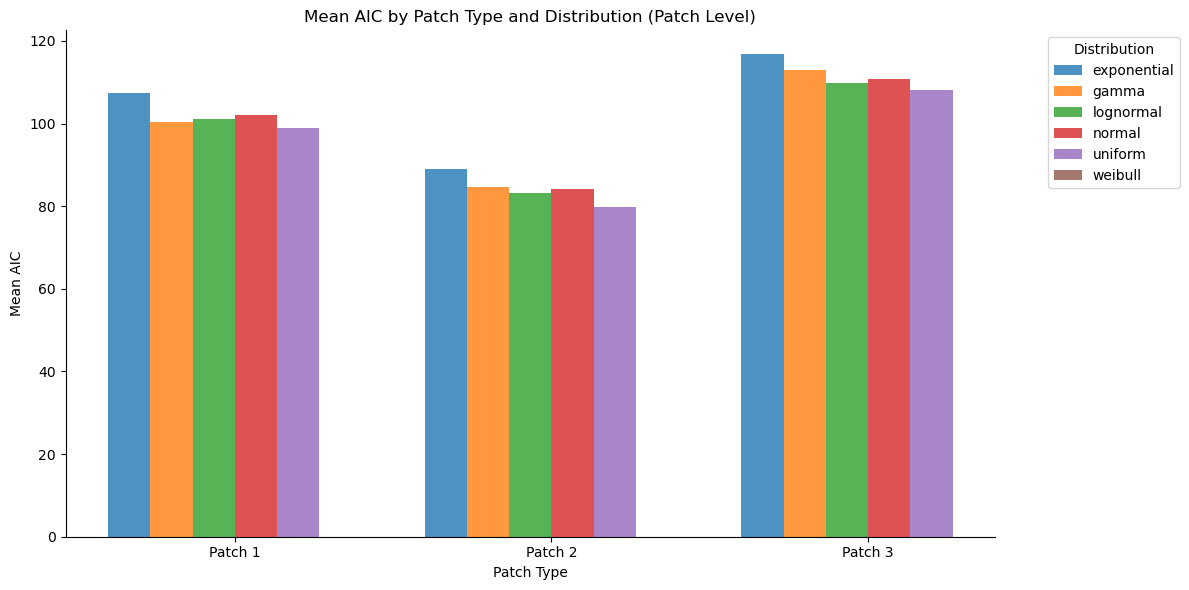

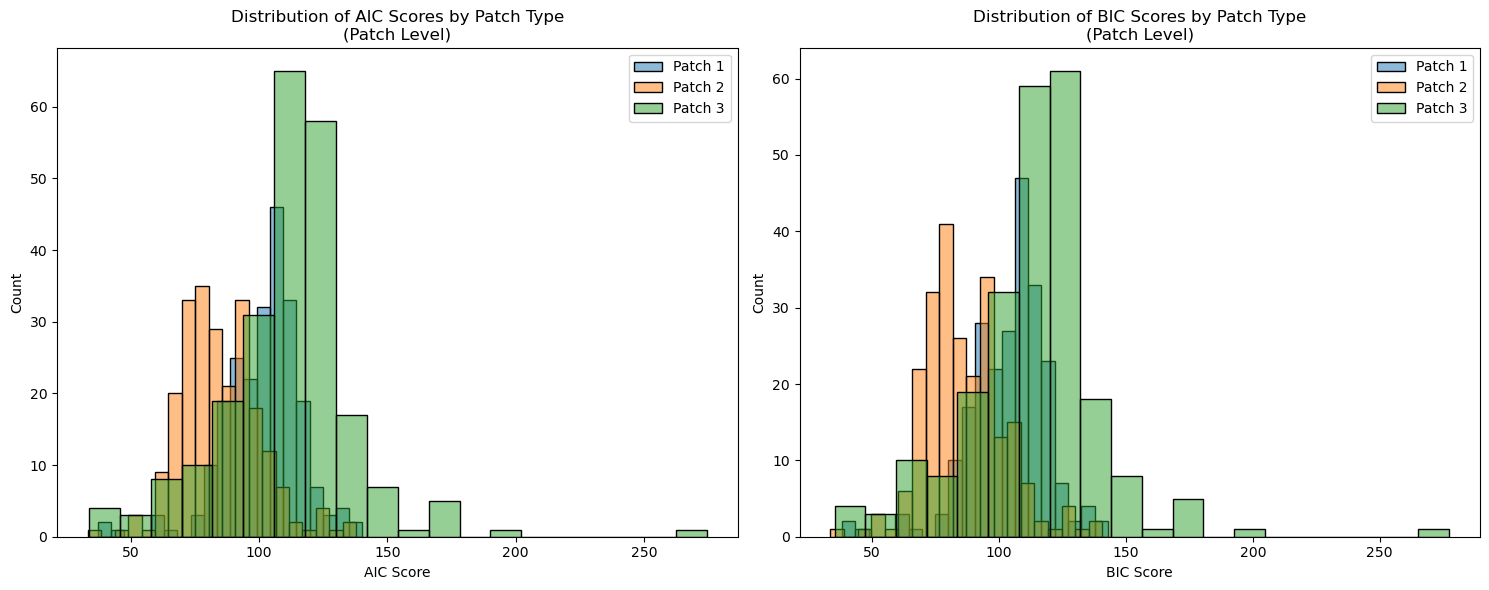

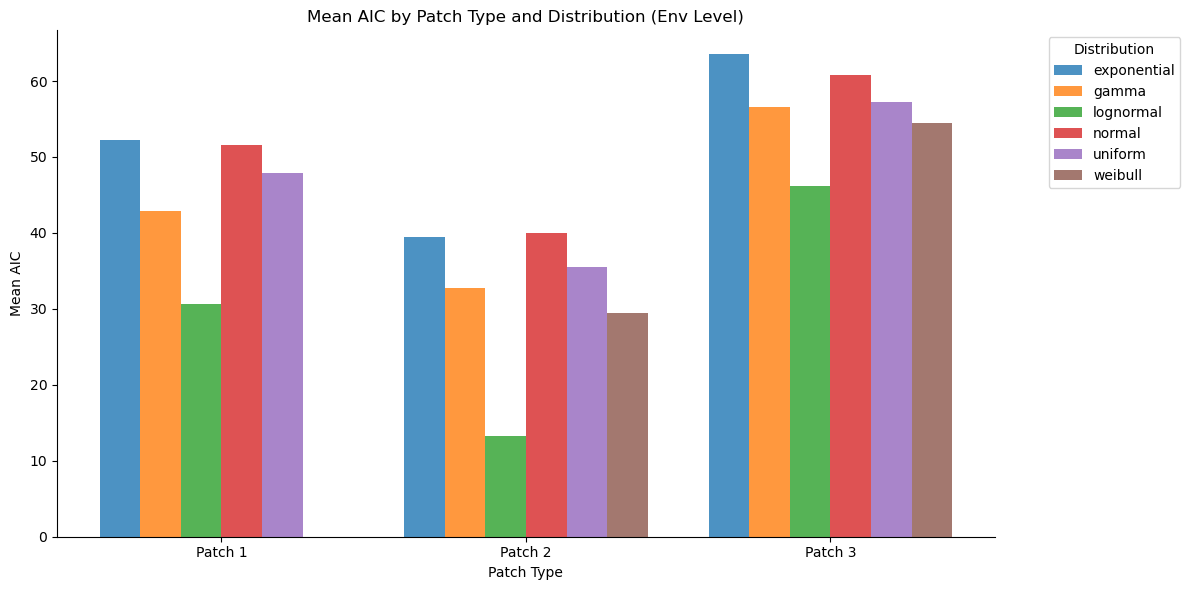

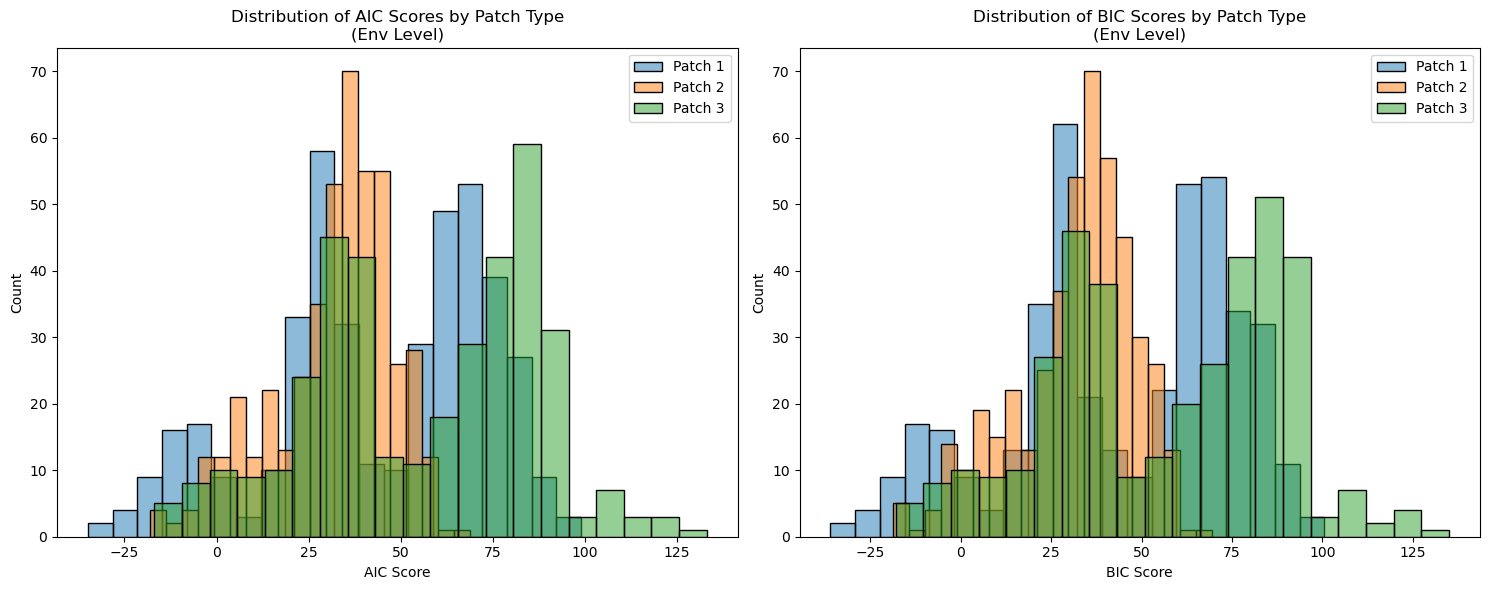

In [15]:
for results_df, level in [(patch_results_df, 'patch'), (env_results_df, 'env')]:
    # Plot AIC and BIC summaries
    plot_summary_scores(results_df, 'aic', level)
    # plot_summary_scores(results_df, 'bic', level)
    plot_score_distributions(results_df, level)

In [14]:
def plot_score_distributions(results_df: pd.DataFrame, level: str):
    """
    Create histograms of AIC and BIC scores.
    
    Args:
        results_df: DataFrame containing the fit results
        level: 'patch' or 'env' to indicate analysis level
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot AIC and BIC distributions
    for metric, ax, title in zip(['aic', 'bic'], [ax1, ax2], 
                                ['AIC Scores', 'BIC Scores']):
        for patch_type in sorted(results_df['patch_type'].unique()):
            patch_data = results_df[results_df['patch_type'] == patch_type]
            
            # Filter out infinite values
            finite_scores = patch_data[metric][~np.isinf(patch_data[metric])]
            if len(finite_scores) > 0:
                sns.histplot(data=finite_scores, ax=ax, label=patch_type, 
                           alpha=0.5, bins=20)

        ax.set_xlabel(f'{metric.upper()} Score')
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of {title} by Patch Type\n({level.title()} Level)')
        ax.legend()
    
    plt.tight_layout()
    # plt.savefig(f'figures/distribution_fits/{level}_score_distributions.png', 
                # bbox_inches='tight', dpi=300)
    # plt.close()
    plt.show()

1. Compute skewness of the data before model fitting
2. Evaluate if current sample size is sufficient for distribution estimation
3. Fit models to population-level distribution for each patch x environment combination with z-score scaling

In [21]:
from scipy.stats import normaltest, skewtest

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

In [22]:
def compute_skewness(data: np.ndarray) -> Tuple[float, float]:
    """
    Compute skewness and perform skewness test.
    
    Args:
        data: Array of observations
    
    Returns:
        Tuple of (skewness value, p-value from test)
    """
    skewness = stats.skew(data)
    _, p_value = skewtest(data)
    return skewness, p_value

In [23]:
def assess_sample_size(data: np.ndarray, alpha: float = 0.05) -> Dict:
    """
    Assess if sample size is sufficient for distribution estimation.
    
    Args:
        data: Array of observations
        alpha: Significance level for power analysis
    
    Returns:
        Dictionary containing assessment results
    """
    n = len(data)
    
    # Rule of thumb checks
    min_sample_size = 30  # Minimum for CLT
    recommended_size = 100  # Recommended for distribution fitting
    
    # Effect size for normality (using d'Agostino-Pearson test)
    _, norm_p_value = normaltest(data)
    
    return {
        'n_samples': n,
        'sufficient_for_clt': n >= min_sample_size,
        'sufficient_for_fitting': n >= recommended_size,
        'normality_p_value': norm_p_value,
        'assessment': 'Sufficient' if n >= recommended_size else 
                     'Minimal' if n >= min_sample_size else 'Insufficient'
    }

In [25]:
df = pd.read_csv("leheron_trialbytrial/leheron_trialbytrial.csv")

In [59]:
def fit_population_distributions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fit distributions to population-level data for each patch x environment combination.
    First normalizes within subjects using scipy.stats.zscore, then combines normalized data.
    
    Args:
        df: DataFrame containing trial data
    
    Returns:
        DataFrame containing fit results
    """
    results = []
    distributions = [
        ('normal', stats.norm),
        ('lognormal', stats.lognorm),
        ('gamma', stats.gamma),
        # ('exponential', stats.expon),
        # ('weibull', stats.weibull_min)
    ]
    
    # Create output directory
    os.makedirs('figures/population_fits', exist_ok=True)
    
    # Create DataFrame to store all normalized times for violin plot
    normalized_data = []
    
    # Analyze each patch x environment combination
    for patch in sorted(df['patch'].unique()):
        for env in sorted(df['env'].unique()):
            # First normalize within each subject
            normalized_times_all = []
            
            for subject in df['sub'].unique():
                # Get subject's overall leaving times
                subject_times = df[df['sub'] == subject]['leaveT'].values
                if len(subject_times) < 5:  # Skip subjects with too few trials
                    continue
                
                # Get this subject's leaving times for this patch x env combination
                leave_times = df[
                    (df['sub'] == subject) & 
                    (df['patch'] == patch) & 
                    (df['env'] == env)
                ]['leaveT'].values
                
                if len(leave_times) > 0:
                    # Normalize within subject using scipy's zscore
                    subject_normalized = stats.zscore(leave_times)
                    normalized_times_all.extend(subject_normalized)
                    
                    # Store normalized data for violin plot
                    normalized_data.extend([
                        {'patch': f'Patch {patch}',
                         'env': f'Env {env}',
                         'normalized_time': t} for t in subject_normalized
                    ])
            
            normalized_times_all = np.array(normalized_times_all)
            
            if len(normalized_times_all) < 30:  # Skip if too few observations
                continue
            
            # Compute skewness
            skewness, skew_p = compute_skewness(normalized_times_all)
            
            # Assess sample size
            size_assessment = assess_sample_size(normalized_times_all)
            
            # Fit distributions
            fit_results = {}
            for dist_name, dist in distributions:
                try:
                    # Fit distribution
                    params = dist.fit(normalized_times_all)
                    
                    # Calculate goodness of fit
                    logL = np.sum(dist.logpdf(normalized_times_all, *params))
                    k = len(params)
                    n = len(normalized_times_all)
                    aic = 2 * k - 2 * logL
                    bic = np.log(n) * k - 2 * logL
                    
                    # Kolmogorov-Smirnov test
                    ks_stat, ks_p = stats.kstest(normalized_times_all, dist.name, params)
                    
                    fit_results[dist_name] = {
                        'params': params,
                        'logL': logL,
                        'aic': aic,
                        'bic': bic,
                        'ks_stat': ks_stat,
                        'ks_p': ks_p
                    }
                except Exception as e:
                    print(f"Failed to fit {dist_name} for Patch {patch}, Env {env}: {str(e)}")
            
            # Plot fits
            plt.figure(figsize=(10, 6))
            plt.hist(normalized_times_all, bins='auto', density=True, alpha=0.6, 
                    label='Data', color='gray')
            
            x = np.linspace(min(normalized_times_all), max(normalized_times_all), 200)
            for dist_name, res in fit_results.items():
                try:
                    dist = dict(distributions)[dist_name]
                    y = dist.pdf(x, *res['params'])
                    plt.plot(x, y, label=f'{dist_name}\nAIC: {res["aic"]:.2f}')
                except:
                    continue
            
            plt.title(f'Patch {patch} - Env {env}\nSkewness: {skewness:.2f} (p={skew_p:.3f})\n'
                     f'N={len(normalized_times_all)} trials')
            plt.xlabel('Normalized Leaving Time (Z-scored within subjects)')
            plt.ylabel('Density')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.savefig(f'figures/population_fits/patch{patch}_env{env}_fits.png', 
                       bbox_inches='tight', dpi=300)
            plt.close()
            
            # Store results
            for dist_name, res in fit_results.items():
                results.append({
                    'patch_type': f'Patch {patch}',
                    'environment': f'Env {env}',
                    'distribution': dist_name,
                    'skewness': skewness,
                    'skewness_p': skew_p,
                    'n_samples': size_assessment['n_samples'],
                    'n_subjects': len(df['sub'].unique()),
                    'sample_size_assessment': size_assessment['assessment'],
                    'normality_p': size_assessment['normality_p_value'],
                    'aic': res['aic'],
                    'bic': res['bic'],
                    'ks_stat': res['ks_stat'],
                    'ks_p': res['ks_p']
                })
    
    # Create violin plot of normalized distributions
    plt.figure(figsize=(12, 6))
    df_normalized = pd.DataFrame(normalized_data)
    
    sns.violinplot(x='patch', y='normalized_time', data=df_normalized, 
                  hue='env', inner='box', palette='Set3',
                  inner_kws=dict(box_width=10, whis_width=1.5, color=".45"))
    
    plt.title('Distribution of Z-scored Leaving Times by Patch and Environment')
    plt.xlabel('Patch Type')
    plt.ylabel('Z-scored Leave Time')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/population_fits/normalized_distributions.png', 
                bbox_inches='tight', dpi=300)
    plt.close()
    
    return pd.DataFrame(results)

In [88]:
# Perform population-level analysis
results_df = fit_population_distributions(df)

/Users/shayan/anaconda3/envs/my_foraging/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


In [89]:
results_df

,patch_type,environment,distribution,skewness,skewness_p,n_samples,n_subjects,sample_size_assessment,normality_p,aic,bic,ks_stat,ks_p
0,Patch 1,Env 1,normal,0.282590,0.092548,206,39,Sufficient,9.162889e-07,588.602676,595.258428,0.075443,0.182076
1,Patch 1,Env 1,lognormal,0.282590,0.092548,206,39,Sufficient,9.162889e-07,583.629148,593.612776,0.067672,0.288920
2,Patch 1,Env 1,gamma,0.282590,0.092548,206,39,Sufficient,9.162889e-07,581.009714,590.993342,0.068016,0.283390
3,Patch 1,Env 2,normal,0.199308,0.067982,498,39,Sufficient,1.789694e-01,1417.262779,1425.683979,0.035072,0.560483
4,Patch 1,Env 2,lognormal,0.199308,0.067982,498,39,Sufficient,1.789694e-01,1415.688089,1428.319889,0.021690,0.969273
5,Patch 1,Env 2,gamma,0.199308,0.067982,498,39,Sufficient,1.789694e-01,1415.642543,1428.274343,0.021526,0.971342
6,Patch 2,Env 1,normal,0.064150,0.650253,286,39,Sufficient,2.303196e-02,815.632841,822.944825,0.046506,0.550457
7,Patch 2,Env 1,lognormal,0.064150,0.650253,286,39,Sufficient,2.303196e-02,817.329269,828.297244,0.043171,0.644541
8,Patch 2,Env 1,gamma,0.064150,0.650253,286,39,Sufficient,2.303196e-02,817.328396,828.296371,0.043875,0.624472
9,Patch 2,Env 2,normal,0.061422,0.658444,297,39,Sufficient,2.460724e-04,846.849489,854.236953,0.050808,0.413585


In [64]:
results_df.to_csv('results/skewness_kurtosis_normality_patch_vs_env.csv')

In [86]:
def plot_score_summaries(results_df: pd.DataFrame):
    """
    Create summary plots of mean AIC and BIC scores by patch type and distribution.
    
    Args:
        results_df: DataFrame containing the distribution fitting results
    """
    # Create figure directory if it doesn't exist
    os.makedirs('figures/population_fits', exist_ok=True)
    
    # Calculate mean scores for each patch type and distribution
    mean_scores = (results_df
        .groupby(['patch_type', 'distribution'])
        .agg({
            'aic': 'mean',
            'bic': 'mean'
        })
        .reset_index()
    )
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Set bar width and positions
    distributions = mean_scores['distribution'].unique()
    n_distributions = len(distributions)
    bar_width = 0.8 / n_distributions
    
    # Plot AIC means with log scale
    for i, dist in enumerate(distributions):
        dist_data = mean_scores[mean_scores['distribution'] == dist]
        x = np.arange(len(dist_data['patch_type'].unique()))
        offset = (i - n_distributions/2 + 0.5) * bar_width
        ax1.bar(x + offset, dist_data['aic'], bar_width, 
               label=dist, alpha=0.8)
    
    # ax1.set_yscale('log')
    ax1.set_title('Mean AIC Scores by Patch Type and Distribution')
    ax1.set_xlabel('Patch Type')
    ax1.set_ylabel('Mean AIC Score (log scale)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(dist_data['patch_type'].unique(), rotation=45)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.legend(title='Distribution')
    
    # Plot BIC means with log scale
    for i, dist in enumerate(distributions):
        dist_data = mean_scores[mean_scores['distribution'] == dist]
        x = np.arange(len(dist_data['patch_type'].unique()))
        offset = (i - n_distributions/2 + 0.5) * bar_width
        ax2.bar(x + offset, dist_data['bic'], bar_width, 
               label=dist, alpha=0.8)
    
    # ax2.set_yscale('log')
    ax2.set_title('Mean BIC Scores by Patch Type and Distribution')
    ax2.set_xlabel('Patch Type')
    ax2.set_ylabel('Mean BIC Score (log scale)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(dist_data['patch_type'].unique(), rotation=45)
    ax2.tick_params(axis='both', labelsize=15)
    ax2.legend(title='Distribution')
    
    # Add grid for better readability
    ax1.grid(True, alpha=0.3, which='both')
    ax2.grid(True, alpha=0.3, which='both')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('figures/population_fits/mean_score_distributions.png', 
                bbox_inches='tight', dpi=300)
    plt.close()
    
    # Create summary statistics table
    summary_stats = (results_df
        .groupby(['patch_type', 'distribution'])
        .agg({
            'aic': ['mean', 'std', 'min'],
            'bic': ['mean', 'std', 'min']
        })
        .round(2)
    )
    
    # Save summary statistics
    summary_stats.to_csv('results/score_summary_stats.csv')
    
    return summary_stats

In [90]:
# Create and print score summaries
summary_stats = plot_score_summaries(results_df)

print("\nBest fitting distributions by AIC:")
best_fits = results_df.loc[results_df.groupby(['patch_type', 'environment'])['aic'].idxmin()]
print(best_fits[['patch_type', 'environment', 'distribution', 'aic', 'ks_p']])

print("\nScore Summary Statistics:")
print(summary_stats)


Best fitting distributions by AIC:
   patch_type environment distribution          aic      ks_p
2     Patch 1       Env 1        gamma   581.009714  0.283390
5     Patch 1       Env 2        gamma  1415.642543  0.971342
6     Patch 2       Env 1       normal   815.632841  0.550457
9     Patch 2       Env 2       normal   846.849489  0.413585
12    Patch 3       Env 1       normal  1533.615739  0.852733
15    Patch 3       Env 2       normal   560.223905  0.118670

Score Summary Statistics:
                             aic                      bic                
                            mean     std     min     mean     std     min
patch_type distribution                                                  
Patch 1    gamma          998.33  590.17  581.01  1009.63  592.05  590.99
           lognormal      999.66  588.35  583.63  1010.97  590.23  593.61
           normal        1002.93  585.95  588.60  1010.47  587.20  595.26
Patch 2    gamma          832.93   22.06  817.33   843.95  

### Skewness, Kurtosis, Normality

In [65]:
def analyze_distribution_characteristics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate distribution characteristics (skewness, kurtosis, normality) for each 
    patch x environment combination at the population level.
    
    Args:
        df: DataFrame containing trial data
    
    Returns:
        DataFrame with distribution characteristics
    """
    results = []
    
    # Analyze each patch x environment combination
    for patch in sorted(df['patch'].unique()):
        for env in sorted(df['env'].unique()):
            # First normalize within each subject
            normalized_times_all = []
            
            for subject in df['sub'].unique():
                # Get subject's overall leaving times
                subject_times = df[df['sub'] == subject]['leaveT'].values
                if len(subject_times) < 5:  # Skip subjects with too few trials
                    continue
                
                # Get this subject's leaving times for this patch x env combination
                leave_times = df[
                    (df['sub'] == subject) & 
                    (df['patch'] == patch) & 
                    (df['env'] == env)
                ]['leaveT'].values
                
                if len(leave_times) > 0:
                    # Normalize within subject using scipy's zscore
                    subject_normalized = stats.zscore(leave_times)
                    normalized_times_all.extend(subject_normalized)
            
            normalized_times_all = np.array(normalized_times_all)
            
            if len(normalized_times_all) < 30:  # Skip if too few observations
                continue
            
            # Calculate distribution characteristics
            skewness = stats.skew(normalized_times_all)
            skewness_stat, skewness_p = stats.skewtest(normalized_times_all)
            
            kurtosis = stats.kurtosis(normalized_times_all)  # Fisher kurtosis (normal = 0)
            
            # D'Agostino-Pearson normality test
            normality_stat, normality_p = stats.normaltest(normalized_times_all)
            
            # Store results
            results.append({
                'patch_type': f'Patch {patch}',
                'environment': f'Env {env}',
                'n_samples': len(normalized_times_all),
                'skewness': skewness,
                'skewness_p': skewness_p,
                'kurtosis': kurtosis,
                'normality_p': normality_p
            })
    
    return pd.DataFrame(results)

In [66]:
df = pd.read_csv("leheron_trialbytrial/leheron_trialbytrial.csv")

In [67]:
results_df = analyze_distribution_characteristics(df)
results_df

,patch_type,environment,n_samples,skewness,skewness_p,kurtosis,normality_p
0,Patch 1,Env 1,206,0.282590,0.092548,-0.924059,9.162889e-07
1,Patch 1,Env 2,498,0.199308,0.067982,-0.100525,1.789694e-01
2,Patch 2,Env 1,286,0.064150,0.650253,-0.584026,2.303196e-02
3,Patch 2,Env 2,297,0.061422,0.658444,-0.739008,2.460724e-04
4,Patch 3,Env 1,539,-0.043971,0.672895,0.026714,8.794608e-01
5,Patch 3,Env 2,196,-0.161557,0.341930,-0.995475,5.598017e-08


In [68]:
results_df.to_csv('results/skewness_kurtosis_normality_patch_vs_env.csv')

In [71]:
# Read the CSVs
# Read the CSVs
patch_env_df = pd.read_csv('results/patch_env_fit_analysis.csv')
skewness_df = pd.read_csv('results/skewness_kurtosis_normality_patch_vs_env.csv')

# Function to round numeric columns to 4 decimal places
def round_numeric_columns(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].round(4)
    return df

# Round the numbers
patch_env_df = round_numeric_columns(patch_env_df)
skewness_df = round_numeric_columns(skewness_df)

# # Save the rounded DataFrames
# patch_env_df.to_csv('results/patch_env_fit_analysis.csv', index=False)
# skewness_df.to_csv('results/skewness_kurtosis_normality_patch_vs_env.csv', index=False)

In [72]:
patch_env_df.head()

,Unnamed: 0,patch_type,environment,distribution,skewness,skewness_p,n_samples,n_subjects,sample_size_assessment,normality_p,aic,bic,ks_stat,ks_p
0,0,Patch 1,Env 1,normal,0.2826,0.0925,206,39,Sufficient,0.000,588.6027,595.2584,0.0754,0.1821
1,1,Patch 1,Env 1,lognormal,0.2826,0.0925,206,39,Sufficient,0.000,583.6291,593.6128,0.0677,0.2889
2,2,Patch 1,Env 1,gamma,0.2826,0.0925,206,39,Sufficient,0.000,581.0097,590.9933,0.0680,0.2834
3,3,Patch 1,Env 2,normal,0.1993,0.0680,498,39,Sufficient,0.179,1417.2628,1425.6840,0.0351,0.5605
4,4,Patch 1,Env 2,lognormal,0.1993,0.0680,498,39,Sufficient,0.179,1415.6881,1428.3199,0.0217,0.9693


In [83]:
patch_env_df.iloc[:, 1:].to_csv('results/patch_env_fit_analysis.csv')
skewness_df.iloc[:, 1:].to_csv('results/skewness_kurtosis_normality_patch_vs_env.csv')

In [85]:
patch_env_df.iloc[:, 1:]

,patch_type,environment,distribution,skewness,skewness_p,n_samples,n_subjects,sample_size_assessment,normality_p,aic,bic,ks_stat,ks_p
0,Patch 1,Env 1,normal,0.2826,0.0925,206,39,Sufficient,0.0000,588.6027,595.2584,0.0754,0.1821
1,Patch 1,Env 1,lognormal,0.2826,0.0925,206,39,Sufficient,0.0000,583.6291,593.6128,0.0677,0.2889
2,Patch 1,Env 1,gamma,0.2826,0.0925,206,39,Sufficient,0.0000,581.0097,590.9933,0.0680,0.2834
3,Patch 1,Env 2,normal,0.1993,0.0680,498,39,Sufficient,0.1790,1417.2628,1425.6840,0.0351,0.5605
4,Patch 1,Env 2,lognormal,0.1993,0.0680,498,39,Sufficient,0.1790,1415.6881,1428.3199,0.0217,0.9693
5,Patch 1,Env 2,gamma,0.1993,0.0680,498,39,Sufficient,0.1790,1415.6425,1428.2743,0.0215,0.9713
6,Patch 2,Env 1,normal,0.0641,0.6503,286,39,Sufficient,0.0230,815.6328,822.9448,0.0465,0.5505
7,Patch 2,Env 1,lognormal,0.0641,0.6503,286,39,Sufficient,0.0230,817.3293,828.2972,0.0432,0.6445
8,Patch 2,Env 1,gamma,0.0641,0.6503,286,39,Sufficient,0.0230,817.3284,828.2964,0.0439,0.6245
9,Patch 2,Env 2,normal,0.0614,0.6584,297,39,Sufficient,0.0002,846.8495,854.2370,0.0508,0.4136


### Subject level Analyzer

In [12]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, List
import os

In [4]:
# Load data
df = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")

In [8]:
class DistributionAnalyzer:
    """Class to analyze and fit distributions to data using scipy's built-in methods."""
    
    def __init__(self):
        # Define distributions to test
        self.distributions = [
            stats.norm, stats.lognorm, stats.gamma
        ]
        self.dist_names = [
            'normal', 'lognormal', 'gamma'
        ]

    def fit_distributions(self, data: np.ndarray) -> Dict:
        """
        Fit multiple distributions to the data and compute goodness-of-fit metrics.
        
        Args:
            data: Array of observations
            
        Returns:
            Dictionary containing fit results for each distribution
        """
        results = {}
        n = len(data)
        
        # Calculate skewness and its p-value
        skewness = stats.skew(data)
        skewness_p = stats.skewtest(data)[1] if len(data) >= 8 else np.nan
        
        for dist, name in zip(self.distributions, self.dist_names):
            try:
                # Fit distribution to data
                params = dist.fit(data)
                
                # Calculate log-likelihood
                logL = np.sum(dist.logpdf(data, *params))
                
                # Calculate AIC and BIC
                k = len(params)  # number of parameters
                aic = 2 * k - 2 * logL
                bic = np.log(n) * k - 2 * logL
                
                # Calculate KS test
                ks_stat, ks_p = stats.kstest(data, dist.name, params)
                
                results[name] = {
                    'params': params,
                    'logL': logL,
                    'aic': aic,
                    'bic': bic,
                    'ks_stat': ks_stat,
                    'ks_p': ks_p,
                    'skewness': skewness,
                    'skewness_p': skewness_p,
                    'distribution': dist
                }
            except Exception as e:
                print(f"Failed to fit {name} distribution: {str(e)}")
                continue
                
        return results

In [56]:
def analyze_subject_level_distributions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze distributions at subject level with both raw and z-scored data.
    Also computes skewness of fitted distributions.
    
    Args:
        df: DataFrame containing trial data
        
    Returns:
        DataFrame containing subject-level analysis results
    """
    analyzer = DistributionAnalyzer()
    results = []
    
    # Create output directories
    os.makedirs('results', exist_ok=True)
    
    for subject in df['sub'].unique():
        # Get subject's data for normalization
        subject_times = df[df['sub'] == subject]['leaveT'].values
        subject_mean = np.mean(subject_times)
        subject_std = np.std(subject_times)
        
        for patch in df['patch'].unique():
            for env in df['env'].unique():
                # Get raw leaving times
                leave_times = df[
                    (df['sub'] == subject) & 
                    (df['patch'] == patch) & 
                    (df['env'] == env)
                ]['leaveT'].values
                
                if len(leave_times) < 5:  # Skip if too few observations
                    continue
                
                # Z-score normalize the data
                z_scored_times = (leave_times - subject_mean) / subject_std
                
                # Fit distributions to both raw and z-scored data
                raw_results = analyzer.fit_distributions(leave_times)
                z_results = analyzer.fit_distributions(z_scored_times)
                
                # Save results for both raw and z-scored data
                for dist_name in analyzer.dist_names:
                    if dist_name in raw_results and dist_name in z_results:
                        # Calculate fitted distribution skewness
                        try:
                            # For raw data
                            raw_dist = raw_results[dist_name]['distribution']
                            raw_params = raw_results[dist_name]['params']
                            raw_fitted_skew = raw_dist.stats(*raw_params, moments='s')
                            
                            # For z-scored data
                            z_dist = z_results[dist_name]['distribution']
                            z_params = z_results[dist_name]['params']
                            z_fitted_skew = z_dist.stats(*z_params, moments='s')
                        except:
                            raw_fitted_skew = np.nan
                            z_fitted_skew = np.nan
                        
                        results.append({
                            'subject': subject,
                            'patch_type': f'Patch {patch}',
                            'environment': f'Env {env}',
                            'distribution': dist_name,
                            'n_samples': len(leave_times),
                            # Raw data metrics
                            'raw_skewness': raw_results[dist_name]['skewness'],
                            'raw_skewness_p': raw_results[dist_name]['skewness_p'],
                            'raw_aic': raw_results[dist_name]['aic'],
                            'raw_bic': raw_results[dist_name]['bic'],
                            'raw_ks_p': raw_results[dist_name]['ks_p'],
                            'raw_fitted_skewness': raw_fitted_skew,  # Added
                            # Z-scored metrics
                            'z_skewness': z_results[dist_name]['skewness'],
                            'z_skewness_p': z_results[dist_name]['skewness_p'],
                            'z_aic': z_results[dist_name]['aic'],
                            'z_bic': z_results[dist_name]['bic'],
                            'z_ks_p': z_results[dist_name]['ks_p'],
                            'z_fitted_skewness': z_fitted_skew  # Added
                        })
    
    return pd.DataFrame(results)

In [10]:
def aggregate_subject_scores(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate subject-level scores to population level.
    
    Args:
        results_df: DataFrame with subject-level results
        
    Returns:
        DataFrame with population-level aggregated scores
    """
    # Group by patch type, environment, and distribution
    population_scores = (results_df
        .groupby(['patch_type', 'environment', 'distribution'])
        .agg({
            'raw_aic': 'sum',  # Sum AICs across subjects
            'z_aic': 'sum',    # Sum z-scored AICs
            'raw_bic': 'sum',  # Sum BICs across subjects
            'z_bic': 'sum',    # Sum z-scored BICs
            'n_samples': 'sum', # Total samples
            'subject': 'nunique'  # Count unique subjects
        })
        .rename(columns={'subject': 'n_subjects'})
        .reset_index()
    )
    
    return population_scores

In [99]:
# Analyze distributions
results_df = analyze_subject_level_distributions(df)

/Users/shayan/anaconda3/envs/my_foraging/lib/python3.9/site-packages/numpy/lib/_polynomial_impl.py:769: RuntimeWarning: overflow encountered in multiply
  y = y * x + pv
/Users/shayan/anaconda3/envs/my_foraging/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


In [100]:
# Filter for lognormal distribution
lognorm_data = results_df[results_df['distribution'] == 'lognormal'].copy()

# Calculate skewness differences
lognorm_data['empirical_skew_diff'] = lognorm_data['raw_skewness'] - lognorm_data['z_skewness']
lognorm_data['fitted_skew_diff'] = lognorm_data['raw_fitted_skewness'] - lognorm_data['z_fitted_skewness']
lognorm_data['z_emp_fit_diff'] = lognorm_data['z_skewness'] - lognorm_data['z_fitted_skewness']

In [81]:
lognorm_data[['subject', 'patch_type', 'environment', 'raw_skewness', 'z_skewness', 'empirical_skew_diff', 'raw_fitted_skewness', 'z_fitted_skewness', 'fitted_skew_diff', 'z_emp_fit_diff']]

,subject,patch_type,environment,raw_skewness,z_skewness,empirical_skew_diff,raw_fitted_skewness,z_fitted_skewness,fitted_skew_diff,z_emp_fit_diff
1,1,Patch 3,Env 1,-0.902647,-0.902647,-1.110223e-15,5.247338e+111,9.866360e+127,-9.866360e+127,-9.866360e+127
4,1,Patch 2,Env 2,-0.391628,-0.391628,2.664535e-15,1.066410e+131,1.067562e-02,1.066410e+131,-4.023032e-01
7,1,Patch 1,Env 2,0.171779,0.171779,8.049117e-16,1.206093e+96,4.438112e+00,1.206093e+96,-4.266332e+00
10,2,Patch 3,Env 1,-0.305188,-0.305188,-9.992007e-16,3.075008e-05,1.275134e-02,-1.272059e-02,-3.179393e-01
13,2,Patch 3,Env 2,0.271921,0.271921,1.165734e-15,1.330697e+99,4.260713e+33,1.330697e+99,-4.260713e+33
...,...,...,...,...,...,...,...,...,...,...
616,39,Patch 3,Env 1,-0.566530,-0.566530,-8.881784e-16,5.426701e-05,8.987547e-03,-8.933280e-03,-5.755176e-01
619,39,Patch 2,Env 1,0.452577,0.452577,-1.110223e-16,3.816126e+112,4.172373e+00,3.816126e+112,-3.719795e+00
622,39,Patch 2,Env 2,-0.158159,-0.158159,-8.326673e-17,1.174348e+101,1.639423e-02,1.174348e+101,-1.745528e-01
625,39,Patch 1,Env 1,0.213472,0.213472,1.859624e-15,4.575736e+123,6.041251e-01,4.575736e+123,-3.906530e-01


In [85]:
lognorm_data[lognorm_data['z_emp_fit_diff']>0][['subject', 'patch_type', 'environment', 'raw_skewness', 'z_skewness', 'empirical_skew_diff', 'raw_fitted_skewness', 'z_fitted_skewness', 'fitted_skew_diff', 'z_emp_fit_diff']]

,subject,patch_type,environment,raw_skewness,z_skewness,empirical_skew_diff,raw_fitted_skewness,z_fitted_skewness,fitted_skew_diff,z_emp_fit_diff
109,7,Patch 1,Env 2,1.147991,1.147991,1.110223e-15,4.071109e+67,0.883150,4.071109e+67,0.264840
175,11,Patch 1,Env 2,1.523823,1.523823,-2.442491e-15,1.355838e+00,1.355651,1.861833e-04,0.168172
211,13,Patch 1,Env 2,0.647253,0.647253,1.110223e-16,5.833541e-01,0.583354,-3.354194e-08,0.063899
244,16,Patch 3,Env 1,0.280613,0.280613,1.054712e-15,2.782660e-01,0.278266,-1.059402e-08,0.002347
490,31,Patch 2,Env 1,0.738109,0.738109,8.881784e-16,1.018376e+98,0.678163,1.018376e+98,0.059946
547,34,Patch 1,Env 2,0.934056,0.934056,1.332268e-15,6.011392e-01,0.601143,-4.114099e-06,0.332913


In [84]:
lognorm_data[lognorm_data['z_fitted_skewness']<0][['subject', 'patch_type', 'environment', 'raw_skewness', 'z_skewness', 'empirical_skew_diff', 'raw_fitted_skewness', 'z_fitted_skewness', 'fitted_skew_diff', 'z_emp_fit_diff']]

,subject,patch_type,environment,raw_skewness,z_skewness,empirical_skew_diff,raw_fitted_skewness,z_fitted_skewness,fitted_skew_diff,z_emp_fit_diff


In [109]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

In [118]:
def plot_raw_vs_zscore_differences(results_df: pd.DataFrame, verbose=False):
    """
    Plot differences between raw and z-scored skewness (both empirical and fitted)
    for lognormal distribution, separated by environment.
    """
    # Filter for lognormal distribution
    lognorm_data = results_df[results_df['distribution'] == 'lognormal'].copy()

    # Ensure consistent patch type ordering
    patch_order = sorted(lognorm_data['patch_type'].unique())
    
    # Calculate skewness differences
    lognorm_data['empirical_skew_diff'] = lognorm_data['raw_skewness'] - lognorm_data['z_skewness']
    lognorm_data['fitted_skew_diff'] = lognorm_data['raw_fitted_skewness'] - lognorm_data['z_fitted_skewness']
    
    # Create diagnostic table
    diagnostic_df = pd.DataFrame({
        'Sample Size': lognorm_data['n_samples'].describe(),
        'Raw Skewness': lognorm_data['raw_skewness'].describe(),
        'Raw Fitted Skewness': lognorm_data['raw_fitted_skewness'].describe(),
        'Z-scored Skewness': lognorm_data['z_skewness'].describe(),
        'Z-scored Fitted Skewness': lognorm_data['z_fitted_skewness'].describe()
    })
    
    if verbose:
        print("\nRaw vs Z-scored Diagnostic Information:")
        print(diagnostic_df.round(3))
    
    # Remove infinite values
    lognorm_data = lognorm_data[
        np.isfinite(lognorm_data['empirical_skew_diff']) & 
        np.isfinite(lognorm_data['fitted_skew_diff'])
    ]
    
    # Clip extreme values for fitted skewness differences
    q1_fitted = lognorm_data['fitted_skew_diff'].quantile(0.25)
    q3_fitted = lognorm_data['fitted_skew_diff'].quantile(0.75)
    iqr_fitted = q3_fitted - q1_fitted
    lower_bound_fitted = q1_fitted - 3 * iqr_fitted
    upper_bound_fitted = q3_fitted + 3 * iqr_fitted
    lognorm_data['fitted_skew_diff_clipped'] = lognorm_data['fitted_skew_diff'].clip(lower_bound_fitted, upper_bound_fitted)
    
    # For each environment
    for env in sorted(lognorm_data['environment'].unique()):
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        env_data = lognorm_data[lognorm_data['environment'] == env]
        
        try:
            # Plot empirical differences
            sns.boxplot(data=env_data, x='patch_type', y='empirical_skew_diff', 
                       ax=ax1, width=0.5, order=patch_order)
            sns.swarmplot(data=env_data, x='patch_type', y='empirical_skew_diff',
                         ax=ax1, size=5, alpha=0.6, color='black', order=patch_order)
            ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            ax1.set_title('Empirical Skewness Differences\n(Raw - Z-scored)')
            ax1.set_ylabel('Skewness Difference')
            
            # Plot fitted differences (clipped)
            sns.boxplot(data=env_data, x='patch_type', y='fitted_skew_diff_clipped',
                       ax=ax2, width=0.5, order=patch_order)
            sns.swarmplot(data=env_data, x='patch_type', y='fitted_skew_diff_clipped',
                         ax=ax2, size=5, alpha=0.6, color='black', order=patch_order)
            ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            ax2.set_title('Fitted Skewness Differences (Clipped)\n(Raw - Z-scored)')
            ax2.set_ylabel('Skewness Difference')
            ax2.set_xlabel('Patch Type')
            
            # Add text showing number of points clipped
            n_clipped = np.sum(lognorm_data['fitted_skew_diff'] != lognorm_data['fitted_skew_diff_clipped'])
            ax2.text(0.04, 1.1, f'Points clipped: {n_clipped}', 
                    transform=ax2.transAxes, verticalalignment='top')
            
            plt.suptitle(f'Raw vs Z-scored Skewness Differences\n{env}', y=1.02)
            plt.tight_layout()
            
            # Save plot
            plt.savefig(f'../figures/subject_level_fits/raw_vs_zscore_skewness_differences_{env}.png', 
                        dpi=300, bbox_inches='tight')
        finally:
            plt.close()
            
    return diagnostic_df

def plot_empirical_vs_fitted_differences(results_df: pd.DataFrame, verbose=False):
    """
    Plot differences between empirical and fitted skewness for z-scored data,
    separated by environment.
    """
    # Filter for lognormal distribution
    lognorm_data = results_df[results_df['distribution'] == 'lognormal'].copy()

    # Ensure consistent patch type ordering
    patch_order = sorted(lognorm_data['patch_type'].unique())
    
    # Calculate difference
    lognorm_data['z_emp_fit_diff'] = lognorm_data['z_skewness'] - lognorm_data['z_fitted_skewness']
    
    # Create diagnostic table
    diagnostic_df = pd.DataFrame({
        'Sample Size': lognorm_data['n_samples'].describe(),
        'Z-scored Skewness': lognorm_data['z_skewness'].describe(),
        'Z-scored Fitted Skewness': lognorm_data['z_fitted_skewness'].describe(),
        'Z-scored Emp vs Fit Diff': lognorm_data['z_emp_fit_diff'].describe()
    })
    
    if verbose:
        print("\nEmpirical vs Fitted Diagnostic Information:")
        print(diagnostic_df.round(3))
    
    # Remove infinite values
    lognorm_data = lognorm_data[np.isfinite(lognorm_data['z_emp_fit_diff'])]
    
    # Clip extreme values
    q1 = lognorm_data['z_emp_fit_diff'].quantile(0.25)
    q3 = lognorm_data['z_emp_fit_diff'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    lognorm_data['z_emp_fit_diff_clipped'] = lognorm_data['z_emp_fit_diff'].clip(lower_bound, upper_bound)
    
    # For each environment
    for env in sorted(lognorm_data['environment'].unique()):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        env_data = lognorm_data[lognorm_data['environment'] == env]
        
        try:
            # Plot z-scored empirical vs fitted differences (clipped)
            sns.boxplot(data=env_data, x='patch_type', y='z_emp_fit_diff_clipped',
                       ax=ax, width=0.5, order=patch_order)
            sns.swarmplot(data=env_data, x='patch_type', y='z_emp_fit_diff_clipped',
                         ax=ax, size=5, alpha=0.6, color='black', order=patch_order)
            ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            ax.set_title('Z-scored Skewness Differences (Clipped)\n(Empirical - Fitted)')
            ax.set_ylabel('Skewness Difference')
            ax.set_xlabel('Patch Type')
            
            # Add text showing number of points clipped
            n_clipped = np.sum(lognorm_data['z_emp_fit_diff'] != lognorm_data['z_emp_fit_diff_clipped'])
            ax.text(0.02, 1.1, f'Points clipped: {n_clipped}', 
                   transform=ax.transAxes, verticalalignment='top')
            
            plt.suptitle(f'Empirical vs Fitted Skewness Differences\n{env}', y=1.02)
            plt.tight_layout()
            
            # Save plot
            plt.savefig(f'../figures/subject_level_fits/empirical_vs_fitted_skewness_differences_{env}.png', 
                        dpi=300, bbox_inches='tight')
        finally:
            plt.close()
            
    return diagnostic_df

In [119]:
# Plot skewness differences
raw_zscore_diagnostics = plot_raw_vs_zscore_differences(results_df)
raw_zscore_diagnostics

/Users/shayan/anaconda3/envs/my_foraging/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/shayan/anaconda3/envs/my_foraging/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


,Sample Size,Raw Skewness,Raw Fitted Skewness,Z-scored Skewness,Z-scored Fitted Skewness
count,210.000000,210.000000,2.100000e+02,210.000000,2.100000e+02
mean,9.209524,0.070038,2.856132e+141,0.070038,1.989581e+158
std,3.856754,0.701677,4.136630e+142,0.701677,inf
min,5.000000,-2.655206,1.452003e-06,-2.655206,2.039739e-03
25%,6.000000,-0.355644,1.822929e+57,-0.355644,1.249734e-02
50%,8.000000,0.063540,2.003923e+92,0.063540,6.026342e-01
75%,12.000000,0.527363,3.242962e+112,0.527363,5.581957e+00
max,21.000000,1.934393,5.994561e+143,1.934393,4.178120e+160


In [115]:
emp_fit_diagnostics = plot_empirical_vs_fitted_differences(results_df)
emp_fit_diagnostics

/Users/shayan/anaconda3/envs/my_foraging/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/shayan/anaconda3/envs/my_foraging/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Sample Size,Z-scored Skewness,Z-scored Fitted Skewness,Z-scored Emp vs Fit Diff
count,210.000000,210.000000,2.100000e+02,2.100000e+02
mean,9.209524,0.070038,1.989581e+158,-1.989581e+158
std,3.856754,0.701677,inf,inf
min,5.000000,-2.655206,2.039739e-03,-4.178120e+160
25%,6.000000,-0.355644,1.249734e-02,-5.012882e+00
50%,8.000000,0.063540,6.026342e-01,-7.019500e-01
75%,12.000000,0.527363,5.581957e+00,-3.090911e-01
max,21.000000,1.934393,4.178120e+160,3.329129e-01


In [27]:
# Aggregate to population level
population_df = aggregate_subject_scores(results_df)
population_df

,patch_type,environment,distribution,raw_aic,z_aic,raw_bic,z_bic,n_samples,n_subjects
0,Patch 1,Env 1,gamma,464.443872,15.053879,436.711448,-12.678544,179,32
1,Patch 1,Env 1,lognormal,-285.781992,12.537565,-313.514415,-15.194858,179,32
2,Patch 1,Env 1,normal,960.766152,389.413334,942.277870,370.925052,179,32
3,Patch 1,Env 2,gamma,2580.390266,1002.376703,2641.662132,1063.648569,498,39
4,Patch 1,Env 2,lognormal,2460.870906,1094.470943,2522.142772,1155.742809,498,39
5,Patch 1,Env 2,normal,2702.512551,1065.441123,2743.360462,1106.289033,498,39
6,Patch 2,Env 1,gamma,1231.895247,304.790976,1229.218380,302.114110,283,38
7,Patch 2,Env 1,lognormal,486.091035,544.544298,483.414168,541.867431,283,38
8,Patch 2,Env 1,normal,1521.045040,602.230412,1519.260463,600.445834,283,38
9,Patch 2,Env 2,gamma,1293.208354,296.412193,1294.332807,297.536646,297,39


In [30]:
def plot_population_scores(population_df: pd.DataFrame, score_type: str = 'aic'):
    """
    Plot population-level score comparisons for different distributions.
    
    Args:
        population_df: DataFrame with population-level scores
        score_type: 'aic' or 'bic'
    """
    # Create figure with two subplots (raw and z-scored)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Setup data for plotting
    raw_col = f'raw_{score_type}'
    z_col = f'z_{score_type}'
    
    # Calculate mean scores for each distribution and patch type
    raw_summary = (population_df
        .groupby(['patch_type', 'distribution'])[raw_col]
        .mean()
        .reset_index()
        .pivot(index='patch_type', columns='distribution', values=raw_col)
    )
    
    z_summary = (population_df
        .groupby(['patch_type', 'distribution'])[z_col]
        .mean()
        .reset_index()
        .pivot(index='patch_type', columns='distribution', values=z_col)
    )
    
    # Plot settings
    bar_width = 0.8 / len(raw_summary.columns)
    x = np.arange(len(raw_summary.index))
    
    # Plot raw scores
    for i, (dist_name, scores) in enumerate(raw_summary.items()):
        offset = (i - len(raw_summary.columns)/2 + 0.5) * bar_width
        ax1.bar(x + offset, scores, bar_width, label=dist_name, alpha=0.8)
    
    ax1.set_xlabel('Patch Type')
    ax1.set_ylabel(f'Mean Raw {score_type.upper()}')
    ax1.set_title(f'Raw {score_type.upper()} by Patch Type and Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(raw_summary.index)
    ax1.legend(title='Distribution')
    
    # Plot z-scored
    for i, (dist_name, scores) in enumerate(z_summary.items()):
        offset = (i - len(z_summary.columns)/2 + 0.5) * bar_width
        ax2.bar(x + offset, scores, bar_width, label=dist_name, alpha=0.8)
    
    ax2.set_xlabel('Patch Type')
    ax2.set_ylabel(f'Mean Z-scored {score_type.upper()}')
    ax2.set_title(f'Z-scored {score_type.upper()} by Patch Type and Distribution')
    ax2.set_xticks(x)
    ax2.set_xticklabels(z_summary.index)
    ax2.legend(title='Distribution')
    
    # Remove top and right spines
    sns.despine()
    plt.tight_layout()
    
    # # Save plot
    # plt.savefig(f'figures/population_{score_type.lower()}_comparison.png', 
    #             bbox_inches='tight', dpi=300)
    # plt.close()
    plt.show()

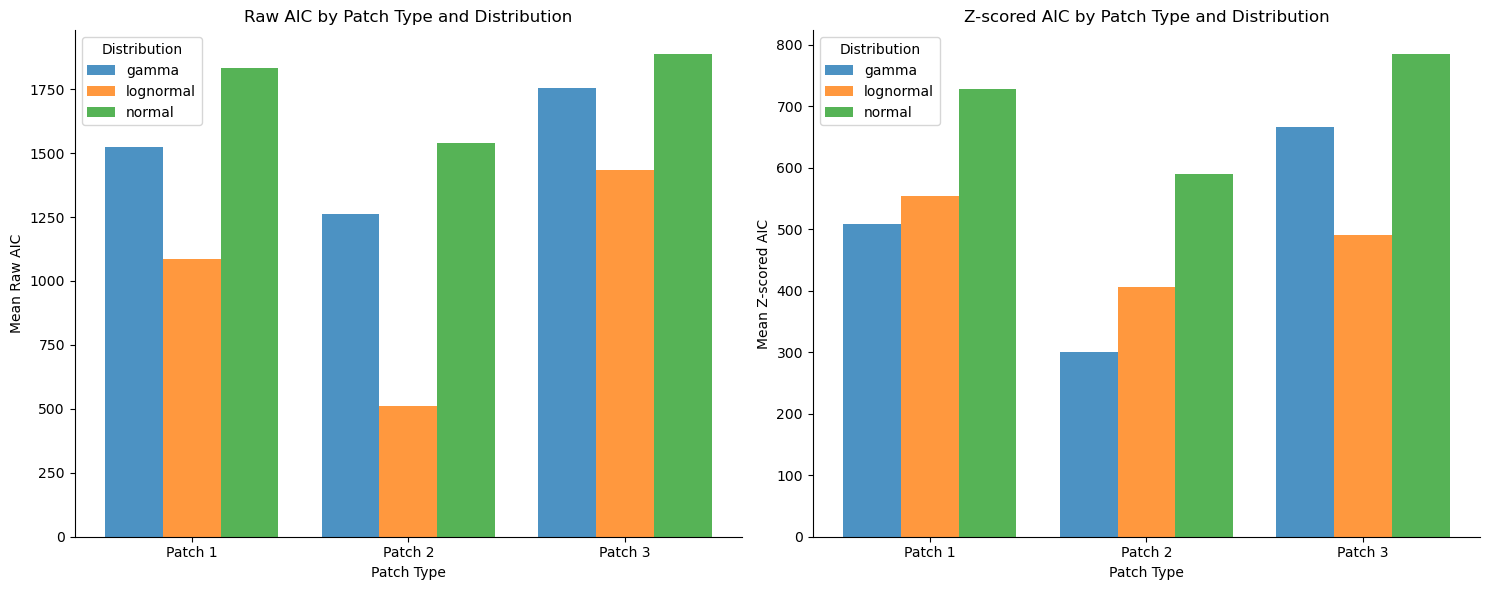

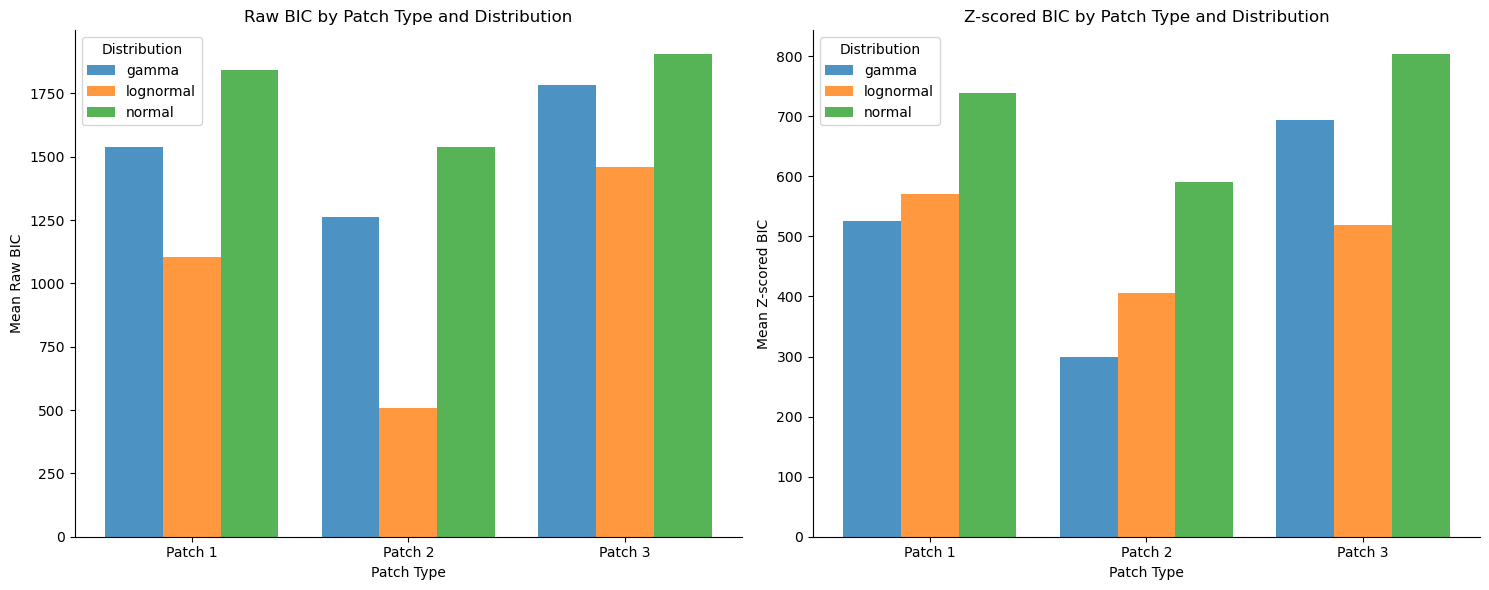

In [31]:
# Create population-level plots
plot_population_scores(population_df, 'aic')
plot_population_scores(population_df, 'bic')

In [120]:
def analyze_patch_subject_distributions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze distributions at patch x subject level with both raw and z-scored data.
    Also computes skewness of fitted distributions.
    
    Args:
        df: DataFrame containing trial data
        
    Returns:
        DataFrame containing patch x subject level analysis results
    """
    analyzer = DistributionAnalyzer()
    results = []
    
    for subject in df['sub'].unique():
        # Get subject's data for z-scoring
        subject_times = df[df['sub'] == subject]['leaveT'].values
        subject_mean = np.mean(subject_times)
        subject_std = np.std(subject_times)
        
        for patch in df['patch'].unique():
            # Get raw leaving times for this subject and patch
            leave_times = df[
                (df['sub'] == subject) & 
                (df['patch'] == patch)
            ]['leaveT'].values
            
            if len(leave_times) < 5:  # Skip if too few observations
                continue
            
            # Z-score normalize the data
            z_scored_times = (leave_times - subject_mean) / subject_std
            
            # Compute raw skewness and its significance
            raw_skew = stats.skew(leave_times)
            raw_skew_p = stats.skewtest(leave_times)[1] if len(leave_times) >= 8 else np.nan
            
            # Compute z-scored skewness and its significance
            z_skew = stats.skew(z_scored_times)
            z_skew_p = stats.skewtest(z_scored_times)[1] if len(z_scored_times) >= 8 else np.nan
            
            # Fit distributions to both raw and z-scored data
            raw_results = analyzer.fit_distributions(leave_times)
            z_results = analyzer.fit_distributions(z_scored_times)
            
            # Save results for both raw and z-scored data
            for dist_name in analyzer.dist_names:
                if dist_name in raw_results and dist_name in z_results:
                    # Calculate fitted distribution skewness
                    try:
                        # For raw data
                        raw_dist = raw_results[dist_name]['distribution']
                        raw_params = raw_results[dist_name]['params']
                        raw_fitted_skew = raw_dist.stats(*raw_params, moments='s')
                        
                        # For z-scored data
                        z_dist = z_results[dist_name]['distribution']
                        z_params = z_results[dist_name]['params']
                        z_fitted_skew = z_dist.stats(*z_params, moments='s')
                    except:
                        raw_fitted_skew = np.nan
                        z_fitted_skew = np.nan
                    
                    results.append({
                        'subject': subject,
                        'patch_type': f'Patch {patch}',
                        'distribution': dist_name,
                        'n_samples': len(leave_times),
                        # Raw data metrics
                        'raw_skewness': raw_skew,
                        'raw_skewness_p': raw_skew_p,
                        'raw_aic': raw_results[dist_name]['aic'],
                        'raw_bic': raw_results[dist_name]['bic'],
                        'raw_ks_p': raw_results[dist_name]['ks_p'],
                        'raw_fitted_skewness': raw_fitted_skew,  # Added
                        # Z-scored metrics
                        'z_skewness': z_skew,
                        'z_skewness_p': z_skew_p,
                        'z_aic': z_results[dist_name]['aic'],
                        'z_bic': z_results[dist_name]['bic'],
                        'z_ks_p': z_results[dist_name]['ks_p'],
                        'z_fitted_skewness': z_fitted_skew  # Added
                    })
    
    return pd.DataFrame(results)

In [121]:
# Analyze at subject x patch level
results_df = analyze_patch_subject_distributions(df)

/Users/shayan/anaconda3/envs/my_foraging/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


In [77]:
lognorm_data = results_df[results_df['distribution'] == 'lognormal'].copy()

# Calculate skewness differences
lognorm_data['empirical_skew_diff'] = lognorm_data['raw_skewness'] - lognorm_data['z_skewness']
lognorm_data['fitted_skew_diff'] = lognorm_data['raw_fitted_skewness'] - lognorm_data['z_fitted_skewness']
# Calculate difference between z-scored empirical and fitted skewness
lognorm_data['z_emp_fit_diff'] = lognorm_data['z_skewness'] - lognorm_data['z_fitted_skewness']

lognorm_data[['subject', 'patch_type', 'raw_skewness', 'z_skewness', 'empirical_skew_diff', 'raw_fitted_skewness', 'z_fitted_skewness', 'fitted_skew_diff', 'z_emp_fit_diff']]

,subject,patch_type,raw_skewness,z_skewness,empirical_skew_diff,raw_fitted_skewness,z_fitted_skewness,fitted_skew_diff,z_emp_fit_diff
1,1,Patch 3,-0.077218,-0.077218,-7.216450e-16,3.318221e+78,0.043666,3.318221e+78,-0.120884
4,1,Patch 2,-0.547977,-0.547977,6.661338e-16,1.088292e+90,0.007847,1.088292e+90,-0.555824
7,1,Patch 1,1.097728,1.097728,-2.220446e-16,3.367658e+71,4.142602,3.367658e+71,-3.044874
10,2,Patch 3,0.091648,0.091648,-9.159340e-16,2.219755e-01,0.221975,3.672950e-07,-0.130327
13,2,Patch 2,0.331883,0.331883,-1.554312e-15,7.888249e-01,0.788828,-2.584195e-06,-0.456945
...,...,...,...,...,...,...,...,...,...
337,38,Patch 2,-0.731851,-0.731851,1.221245e-15,2.797095e-06,0.007660,-7.657450e-03,-0.739511
340,38,Patch 1,-0.805382,-0.805382,2.664535e-15,5.174802e-07,0.005862,-5.861820e-03,-0.811244
343,39,Patch 3,0.131184,0.131184,-3.608225e-16,1.202703e-01,0.120270,-1.464601e-07,0.010914
346,39,Patch 2,0.104667,0.104667,-1.804112e-16,2.122053e+58,1.125608,2.122053e+58,-1.020941


In [78]:
lognorm_data[lognorm_data['z_fitted_skewness']<0][['subject', 'patch_type', 'raw_skewness', 'z_skewness', 'empirical_skew_diff', 'raw_fitted_skewness', 'z_fitted_skewness', 'fitted_skew_diff', 'z_emp_fit_diff']]

,subject,patch_type,raw_skewness,z_skewness,empirical_skew_diff,raw_fitted_skewness,z_fitted_skewness,fitted_skew_diff,z_emp_fit_diff


In [42]:
results_df[["subject", "patch_type", "n_samples", "raw_skewness", "raw_skewness_p", "z_skewness", "z_skewness_p",
            "distribution", "z_ks_p", "raw_ks_p", 'raw_fitted_skewness', 'z_fitted_skewness']].drop_duplicates().head(20)

,subject,patch_type,n_samples,raw_skewness,raw_skewness_p,z_skewness,z_skewness_p,distribution,z_ks_p,raw_ks_p,raw_fitted_skewness,z_fitted_skewness
0,1,Patch 3,9,-0.077218,0.893260,-0.077218,0.893260,normal,0.676071,0.676071,0.000000e+00,0.000000
1,1,Patch 3,9,-0.077218,0.893260,-0.077218,0.893260,lognormal,0.680336,0.028165,3.318221e+78,0.043666
2,1,Patch 3,9,-0.077218,0.893260,-0.077218,0.893260,gamma,0.687007,0.684407,6.183379e-02,0.064261
3,1,Patch 2,8,-0.547977,0.357883,-0.547977,0.357883,normal,0.760181,0.760181,0.000000e+00,0.000000
4,1,Patch 2,8,-0.547977,0.357883,-0.547977,0.357883,lognormal,0.752124,0.019602,1.088292e+90,0.007847
5,1,Patch 2,8,-0.547977,0.357883,-0.547977,0.357883,gamma,0.736572,0.740254,1.213759e-01,0.137412
6,1,Patch 1,10,1.097728,0.059593,1.097728,0.059593,normal,0.743251,0.743251,0.000000e+00,0.000000
7,1,Patch 1,10,1.097728,0.059593,1.097728,0.059593,lognormal,0.782792,0.016511,3.367658e+71,4.142602
8,1,Patch 1,10,1.097728,0.059593,1.097728,0.059593,gamma,0.352782,0.382265,2.463933e+00,2.207280
9,2,Patch 3,24,0.091648,0.825766,0.091648,0.825766,normal,0.832532,0.832532,0.000000e+00,0.000000


In [54]:
def plot_patch_subject_skewness_differences(results_df: pd.DataFrame, min_samples: int = 10):
    """
    Plot differences in skewness between raw and z-scored data for lognormal distribution
    at the patch x subject level, plus difference between z-scored empirical and fitted skewness.
    
    Args:
        results_df: DataFrame containing patch x subject level analysis results
        min_samples: Minimum number of samples required for inclusion (default: 10)
    """
    # Filter for lognormal distribution
    lognorm_data = results_df[results_df['distribution'] == 'lognormal'].copy()
    
    # Print initial sample size information
    print("\nInitial data summary:")
    print(f"Total number of observations: {len(lognorm_data)}")
    print("\nSample size distribution:")
    print(lognorm_data['n_samples'].describe())
    
    # Filter based on n_samples
    print(f"\nFiltering for n_samples >= {min_samples}")
    print(f"Observations removed: {len(lognorm_data[lognorm_data['n_samples'] < min_samples])}")
    lognorm_data = lognorm_data[lognorm_data['n_samples'] >= min_samples]
    print(f"Remaining observations: {len(lognorm_data)}")
    
    # Calculate skewness differences
    lognorm_data['empirical_skew_diff'] = lognorm_data['raw_skewness'] - lognorm_data['z_skewness']
    lognorm_data['fitted_skew_diff'] = lognorm_data['raw_fitted_skewness'] - lognorm_data['z_fitted_skewness']
    # Calculate difference between z-scored empirical and fitted skewness
    lognorm_data['z_emp_fit_diff'] = lognorm_data['z_skewness'] - lognorm_data['z_fitted_skewness']
    
    # Print diagnostic information
    print("\nDiagnostic Information:")
    print("\nRaw fitted skewness values:")
    print(lognorm_data['raw_fitted_skewness'].describe())
    print("\nZ-scored fitted skewness values:")
    print(lognorm_data['z_fitted_skewness'].describe())
    print("\nZ-scored empirical vs fitted difference:")
    print(lognorm_data['z_emp_fit_diff'].describe())
    
    # Remove any remaining infinite values
    lognorm_data = lognorm_data[
        np.isfinite(lognorm_data['empirical_skew_diff']) & 
        np.isfinite(lognorm_data['fitted_skew_diff']) &
        np.isfinite(lognorm_data['z_emp_fit_diff'])
    ]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    try:
        # Plot empirical differences
        sns.boxplot(data=lognorm_data, x='patch_type', y='empirical_skew_diff', 
                   ax=ax1, width=0.5)
        sns.swarmplot(data=lognorm_data, x='patch_type', y='empirical_skew_diff',
                     ax=ax1, size=5, alpha=0.6, color='black')
        ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax1.set_title('Empirical Skewness Differences\n(Raw - Z-scored)')
        ax1.set_ylabel('Skewness Difference')
        
        # Plot z-scored empirical vs fitted differences
        sns.boxplot(data=lognorm_data, x='patch_type', y='z_emp_fit_diff',
                   ax=ax2, width=0.5)
        sns.swarmplot(data=lognorm_data, x='patch_type', y='z_emp_fit_diff',
                     ax=ax2, size=5, alpha=0.6, color='black')
        ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax2.set_title('Z-scored Skewness Differences\n(Empirical - Fitted)')
        ax2.set_ylabel('Skewness Difference')
        ax2.set_xlabel('Patch Type')
        
        # Add text showing minimum samples threshold
        ax1.text(0.02, 0.98, f'Minimum samples per subject: {min_samples}', 
                transform=ax1.transAxes, verticalalignment='top')
        
        plt.suptitle('Lognormal Distribution Skewness Differences\nPatch x Subject Level', y=1.02)
        plt.tight_layout()
        
        # Save plot
        plt.savefig('../figures/subject_level_fits/patch_subject_lognormal_skewness_differences.png', 
                    dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"\nError plotting: {str(e)}")
        print("Data summary:")
        print(lognorm_data[['empirical_skew_diff', 'z_emp_fit_diff']].describe())
    finally:
        plt.close()

    # Print summary statistics for valid data
    print("\nLognormal Skewness Difference Summary Statistics:")
    summary = (lognorm_data
        .groupby(['patch_type'])
        .agg({
            'empirical_skew_diff': ['mean', 'std', 'count'],
            'fitted_skew_diff': ['mean', 'std'],
            'z_emp_fit_diff': ['mean', 'std'],
            'n_samples': ['mean', 'min', 'max']
        })
        .round(3)
    )
    print(summary)
    
    # Perform statistical tests
    print("\nStatistical Tests:")
    for patch in lognorm_data['patch_type'].unique():
        patch_data = lognorm_data[lognorm_data['patch_type'] == patch]
        
        print(f"\n{patch}:")
        # Empirical differences
        t_stat, p_val = stats.ttest_1samp(patch_data['empirical_skew_diff'].values, 0)
        print(f"Empirical differences (Raw - Z-scored):")
        print(f"One-sample t-test (H0: diff = 0): t = {t_stat:.3f}, p = {p_val:.3f}")
        
        # Z-scored empirical vs fitted differences
        t_stat, p_val = stats.ttest_1samp(patch_data['z_emp_fit_diff'].values, 0)
        print(f"Z-scored differences (Empirical - Fitted):")
        print(f"One-sample t-test (H0: diff = 0): t = {t_stat:.3f}, p = {p_val:.3f}")

In [140]:
def plot_patch_subject_raw_vs_zscore(results_df: pd.DataFrame, min_samples: int = 10, verbose: bool = False):
    """
    Plot differences between raw and z-scored skewness (both empirical and fitted)
    at the patch x subject level.
    """
    # Filter for lognormal distribution
    lognorm_data = results_df[results_df['distribution'] == 'lognormal'].copy()
    
    # Filter based on n_samples
    if verbose:
        print(f"\nFiltering for n_samples >= {min_samples}")
        print(f"Initial observations: {len(lognorm_data)}")
        print(f"Observations removed: {len(lognorm_data[lognorm_data['n_samples'] < min_samples])}")
    
    lognorm_data = lognorm_data[lognorm_data['n_samples'] >= min_samples]
    
    if verbose:
        print(f"Remaining observations: {len(lognorm_data)}")
    
    # Ensure consistent patch type ordering
    patch_order = sorted(lognorm_data['patch_type'].unique())
    
    # Calculate skewness differences
    lognorm_data['empirical_skew_diff'] = lognorm_data['raw_skewness'] - lognorm_data['z_skewness']
    lognorm_data['fitted_skew_diff'] = lognorm_data['raw_fitted_skewness'] - lognorm_data['z_fitted_skewness']
    
    # Create diagnostic table
    diagnostic_df = pd.DataFrame({
        'Sample Size': lognorm_data['n_samples'].describe(),
        'Raw Skewness': lognorm_data['raw_skewness'].describe(),
        'Raw Fitted Skewness': lognorm_data['raw_fitted_skewness'].describe(),
        'Z-scored Skewness': lognorm_data['z_skewness'].describe(),
        'Z-scored Fitted Skewness': lognorm_data['z_fitted_skewness'].describe()
    })
    
    if verbose:
        print("\nRaw vs Z-scored Diagnostic Information:")
        print(diagnostic_df.round(3))
    
    # Remove infinite values
    lognorm_data = lognorm_data[
        np.isfinite(lognorm_data['empirical_skew_diff']) & 
        np.isfinite(lognorm_data['fitted_skew_diff'])
    ]
    
    # Clip extreme values for fitted skewness differences
    q1_fitted = lognorm_data['fitted_skew_diff'].quantile(0.25)
    q3_fitted = lognorm_data['fitted_skew_diff'].quantile(0.75)
    iqr_fitted = q3_fitted - q1_fitted
    lower_bound_fitted = q1_fitted - 3 * iqr_fitted
    upper_bound_fitted = q3_fitted + 3 * iqr_fitted
    lognorm_data['fitted_skew_diff_clipped'] = lognorm_data['fitted_skew_diff'].clip(lower_bound_fitted, upper_bound_fitted)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    try:
        # Plot empirical differences
        sns.boxplot(data=lognorm_data, x='patch_type', y='empirical_skew_diff', 
                   ax=ax1, width=0.5, order=patch_order)
        sns.swarmplot(data=lognorm_data, x='patch_type', y='empirical_skew_diff',
                     ax=ax1, size=5, alpha=0.6, color='black', order=patch_order)
        ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax1.set_title('Empirical Skewness Differences\n(Raw - Z-scored)')
        ax1.set_ylabel('Skewness Difference')
        
        # Plot fitted differences (clipped)
        sns.boxplot(data=lognorm_data, x='patch_type', y='fitted_skew_diff_clipped',
                   ax=ax2, width=0.5, order=patch_order)
        sns.swarmplot(data=lognorm_data, x='patch_type', y='fitted_skew_diff_clipped',
                     ax=ax2, size=5, alpha=0.6, color='black', order=patch_order)
        ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax2.set_title('Fitted Skewness Differences (Clipped)\n(Raw - Z-scored)')
        ax2.set_ylabel('Skewness Difference')
        ax2.set_xlabel('Patch Type')
        
        # Add text showing minimum samples and clipped points
        ax1.text(0.02, 1.1, f'Minimum samples per subject: {min_samples}', 
                transform=ax1.transAxes, verticalalignment='top')
        n_clipped = np.sum(lognorm_data['fitted_skew_diff'] != lognorm_data['fitted_skew_diff_clipped'])
        ax2.text(0.02, 1.1, f'Points clipped: {n_clipped}', 
                transform=ax2.transAxes, verticalalignment='top')
        
        plt.suptitle('Raw vs Z-scored Skewness Differences\nPatch x Subject Level', y=1.02)
        plt.tight_layout()
        
        plt.savefig('../figures/subject_level_fits/patch_subject_raw_vs_zscore_differences.png', 
                    dpi=300, bbox_inches='tight')
    finally:
        plt.close()
    
    return diagnostic_df

def plot_patch_subject_emp_vs_fitted(results_df: pd.DataFrame, min_samples: int = 10, verbose: bool = False):
    """
    Plot differences between empirical and fitted skewness for z-scored data
    at the patch x subject level.
    """
    # Filter for lognormal distribution
    lognorm_data = results_df[results_df['distribution'] == 'lognormal'].copy()
    
    # Filter based on n_samples
    lognorm_data = lognorm_data[lognorm_data['n_samples'] >= min_samples]
    
    # Ensure consistent patch type ordering
    patch_order = sorted(lognorm_data['patch_type'].unique())
    
    # Calculate difference
    lognorm_data['z_emp_fit_diff'] = lognorm_data['z_skewness'] - lognorm_data['z_fitted_skewness']
    
    # Create diagnostic table
    diagnostic_df = pd.DataFrame({
        'Sample Size': lognorm_data['n_samples'].describe(),
        'Z-scored Skewness': lognorm_data['z_skewness'].describe(),
        'Z-scored Fitted Skewness': lognorm_data['z_fitted_skewness'].describe(),
        'Z-scored Emp vs Fit Diff': lognorm_data['z_emp_fit_diff'].describe()
    })
    
    if verbose:
        print("\nEmpirical vs Fitted Diagnostic Information:")
        print(diagnostic_df.round(3))
    
    # Remove infinite values
    lognorm_data = lognorm_data[np.isfinite(lognorm_data['z_emp_fit_diff'])]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    try:
        # Plot z-scored empirical vs fitted differences
        sns.boxplot(data=lognorm_data, x='patch_type', y='z_emp_fit_diff',
                   ax=ax, width=0.5, order=patch_order)
        sns.swarmplot(data=lognorm_data, x='patch_type', y='z_emp_fit_diff',
                     ax=ax, size=5, alpha=0.6, color='black', order=patch_order)
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax.set_title('Z-scored Skewness Differences\n(Empirical - Fitted)')
        ax.set_ylabel('Skewness Difference')
        ax.set_xlabel('Patch Type')
        
        # Add text showing minimum samples
        ax.text(0.02, 1.1, f'Minimum samples per subject: {min_samples}', 
               transform=ax.transAxes, verticalalignment='top')
        
        plt.suptitle('Empirical vs Fitted Skewness Differences\nPatch x Subject Level', y=1.02)
        plt.tight_layout()
        
        plt.savefig('../figures/subject_level_fits/patch_subject_emp_vs_fitted_differences.png', 
                    dpi=300, bbox_inches='tight')
    finally:
        plt.close()
    
    return diagnostic_df

In [141]:
raw_zscore_diag = plot_patch_subject_raw_vs_zscore(results_df, min_samples=0, verbose=False)
raw_zscore_diag

,Sample Size,Raw Skewness,Raw Fitted Skewness,Z-scored Skewness,Z-scored Fitted Skewness
count,117.000000,117.000000,1.170000e+02,117.000000,117.000000
mean,17.282051,0.109737,9.301645e+87,0.109737,0.706563
std,4.122784,0.619980,1.006127e+89,0.619980,1.212600
min,8.000000,-2.100363,5.174802e-07,-2.100363,0.003434
25%,14.000000,-0.208449,4.829452e-05,-0.208449,0.015523
50%,17.000000,0.112082,4.382607e-01,0.112082,0.281573
75%,20.000000,0.444614,1.963807e+00,0.444614,0.816637
max,29.000000,1.787197,1.088292e+90,1.787197,6.139653


In [130]:
emp_fitted_diag = plot_patch_subject_emp_vs_fitted(results_df, min_samples=0, verbose=False)
emp_fitted_diag

,Sample Size,Z-scored Skewness,Z-scored Fitted Skewness,Z-scored Emp vs Fit Diff
count,117.000000,117.000000,117.000000,117.000000
mean,17.282051,0.109737,0.706563,-0.596826
std,4.122784,0.619980,1.212600,1.015965
min,8.000000,-2.100363,0.003434,-5.712687
25%,14.000000,-0.208449,0.015523,-0.722371
50%,17.000000,0.112082,0.281573,-0.244862
75%,20.000000,0.444614,0.816637,-0.107984
max,29.000000,1.787197,6.139653,0.500876


In [70]:
df_2.to_csv('../results/subject_patch_fit_analysis.csv')

In [36]:
def aggregate_to_population(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate subject-level scores to population level by patch type.
    
    The aggregation follows these principles:
    1. AIC/BIC scores are summed across subjects (due to log-likelihood additivity)
    2. Sample sizes are summed
    3. Skewness is averaged (as it's a standardized measure)
    
    Args:
        results_df: DataFrame with subject-level results
        
    Returns:
        DataFrame with population-level metrics by patch type
    """
    population_scores = (results_df
        .groupby(['patch_type', 'distribution'])
        .agg({
            'n_samples': 'sum',
            'subject': 'nunique',
            'raw_aic': 'sum',
            'raw_bic': 'sum',
            'raw_skewness': 'mean',
            'raw_skewness_p': lambda x: stats.combine_pvalues(x.dropna())[1],
            'z_aic': 'sum',
            'z_bic': 'sum',
            'z_skewness': 'mean',
            'z_skewness_p': lambda x: stats.combine_pvalues(x.dropna())[1]
        })
        .rename(columns={'subject': 'n_subjects'})
        .reset_index()
    )
    
    return population_scores

In [37]:
def plot_skewness_by_patch(results_df: pd.DataFrame):
    """Plot skewness distributions by patch type"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw skewness
    sns.boxplot(data=results_df, x='patch_type', y='raw_skewness', ax=ax1)
    ax1.set_title('Distribution of Raw Skewness by Patch Type')
    ax1.axhline(y=0, color='r', linestyle='--')
    
    # Z-scored skewness
    sns.boxplot(data=results_df, x='patch_type', y='z_skewness', ax=ax2)
    ax2.set_title('Distribution of Z-scored Skewness by Patch Type')
    ax2.axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    # plt.savefig('figures/skewness_by_patch.png', dpi=300, bbox_inches='tight')
    # plt.close()
    plt.show()

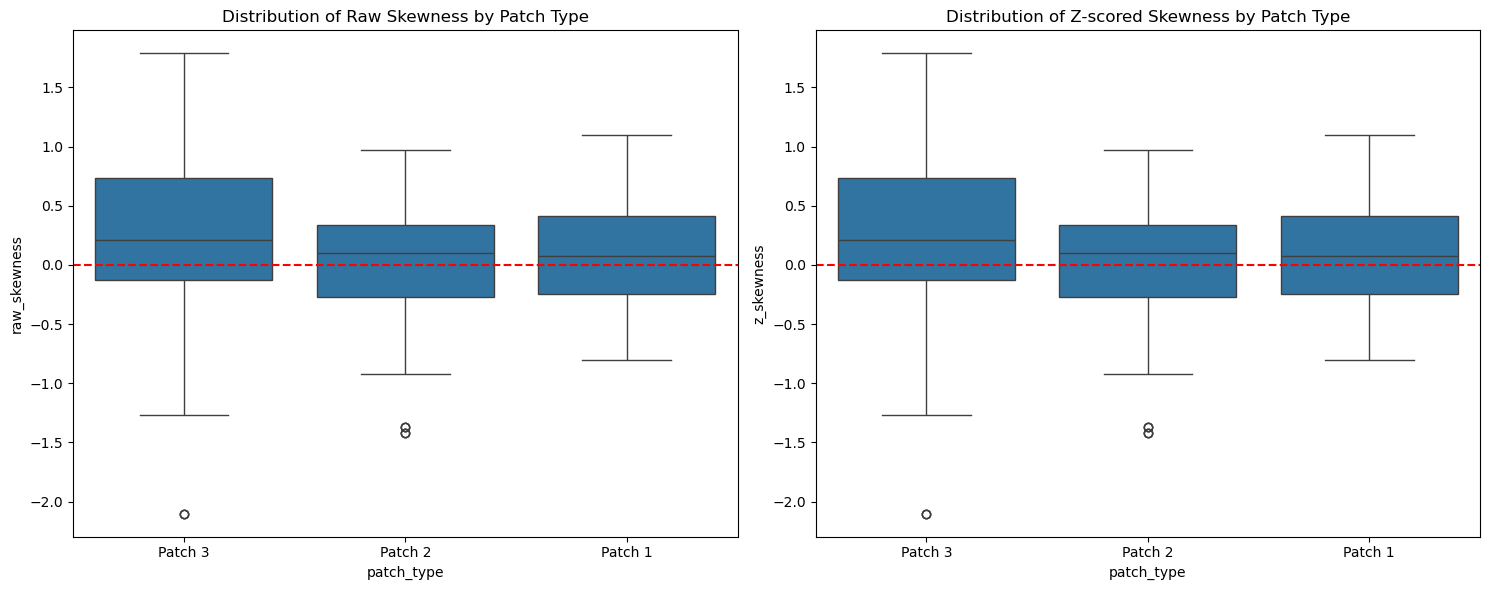

In [38]:
# Create subject-level plots
plot_skewness_by_patch(results_df)

In [39]:
def plot_population_scores(pop_df: pd.DataFrame):
    """Plot population-level AIC/BIC scores by patch type and distribution"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot settings
    bar_width = 0.8 / len(pop_df['distribution'].unique())
    x = np.arange(len(pop_df['patch_type'].unique()))
    
    # Function to create bars
    def plot_bars(data, metric, ax, title):
        for i, dist in enumerate(sorted(data['distribution'].unique())):
            dist_data = data[data['distribution'] == dist]
            offset = (i - len(data['distribution'].unique())/2 + 0.5) * bar_width
            ax.bar(x + offset, dist_data[metric], bar_width, 
                  label=dist, alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(sorted(data['patch_type'].unique()))
        ax.set_title(title)
        ax.legend(title='Distribution')
    
    # Create all plots
    plot_bars(pop_df, 'raw_aic', ax1, 'Raw AIC by Patch Type')
    plot_bars(pop_df, 'z_aic', ax2, 'Z-scored AIC by Patch Type')
    plot_bars(pop_df, 'raw_bic', ax3, 'Raw BIC by Patch Type')
    plot_bars(pop_df, 'z_bic', ax4, 'Z-scored BIC by Patch Type')
    
    # plt.tight_layout()
    # plt.savefig('figures/population_scores.png', dpi=300, bbox_inches='tight')
    # plt.close()
    plt.show()


Skewness Analysis Summary:
           raw_skewness      z_skewness      n_subjects n_samples
                   mean  std       mean  std      first     first
patch_type                                                       
Patch 1           0.128  0.0      0.128  0.0         39       704
Patch 2          -0.009  0.0     -0.009  0.0         39       583
Patch 3           0.210  0.0      0.210  0.0         39       735


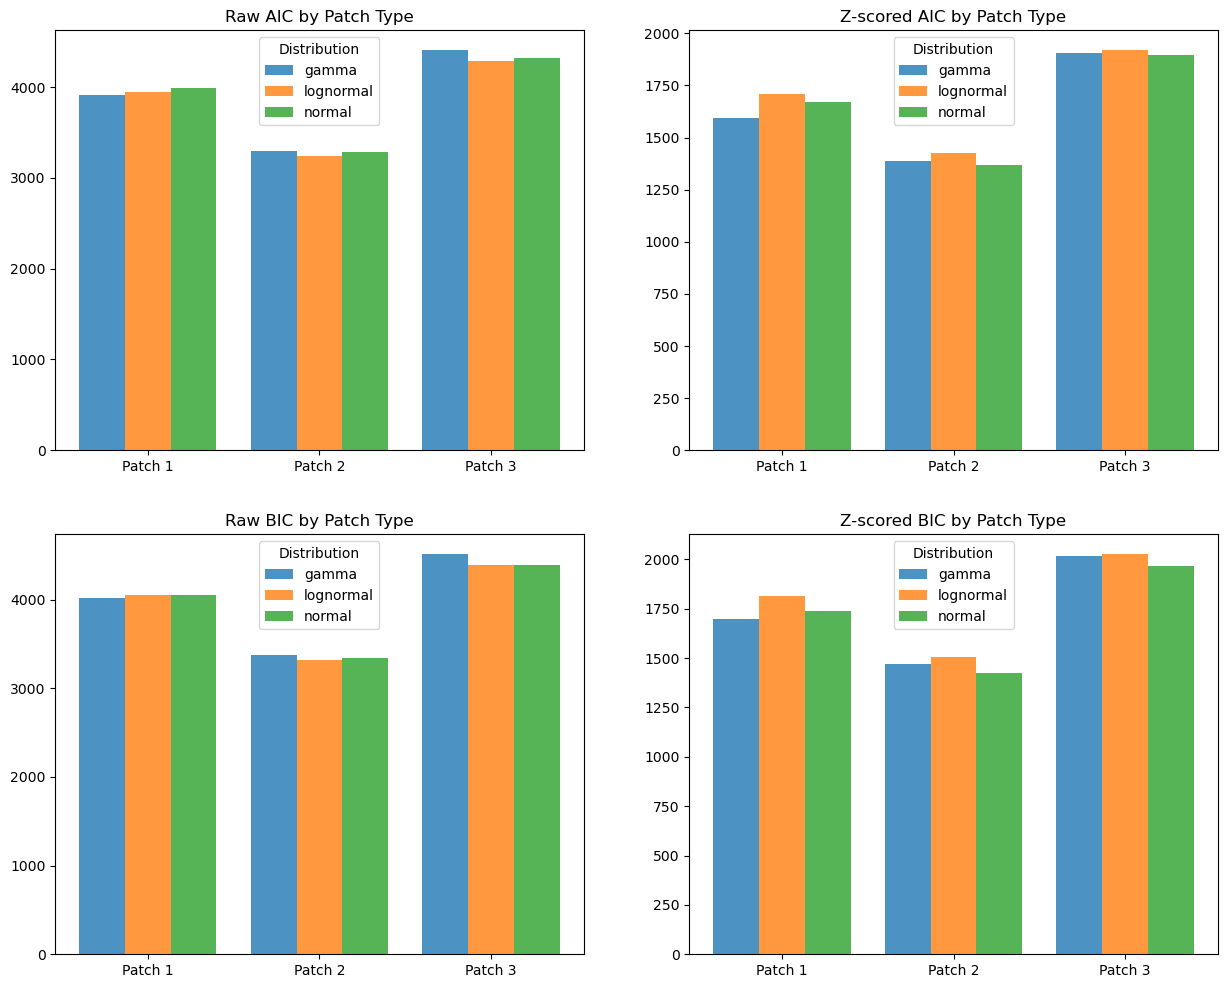

In [40]:
# Aggregate to population level
pop_df = aggregate_to_population(results_df)

# Print summary statistics
print("\nSkewness Analysis Summary:")
summary = pop_df.groupby('patch_type').agg({
    'raw_skewness': ['mean', 'std'],
    'z_skewness': ['mean', 'std'],
    'n_subjects': 'first',
    'n_samples': 'first'
}).round(3)
print(summary)

# Create population-level plots
plot_population_scores(pop_df)

In [41]:
pop_df

,patch_type,distribution,n_samples,n_subjects,raw_aic,raw_bic,raw_skewness,raw_skewness_p,z_aic,z_bic,z_skewness,z_skewness_p
0,Patch 1,gamma,704,39,3912.986077,4015.091810,0.128462,0.480524,1595.323614,1697.429347,0.128462,0.480524
1,Patch 1,lognormal,704,39,3944.464275,4046.570008,0.128462,0.480524,1710.205418,1812.311150,0.128462,0.480524
2,Patch 1,normal,704,39,3985.732550,4053.803038,0.128462,0.480524,1669.914554,1737.985043,0.128462,0.480524
3,Patch 2,gamma,583,39,3300.231446,3379.642740,-0.009238,0.259084,1388.161525,1467.572819,-0.009238,0.259084
4,Patch 2,lognormal,583,39,3243.321570,3322.732864,-0.009238,0.259084,1426.831311,1506.242605,-0.009238,0.259084
5,Patch 2,normal,583,39,3283.189244,3336.130107,-0.009238,0.259084,1369.379009,1422.319872,-0.009238,0.259084
6,Patch 3,gamma,735,39,4404.497917,4511.096907,0.209988,0.000010,1907.431691,2014.030681,0.209988,0.000010
7,Patch 3,lognormal,735,39,4287.556001,4394.154991,0.209988,0.000010,1918.633848,2025.232838,0.209988,0.000010
8,Patch 3,normal,735,39,4316.738269,4387.804263,0.209988,0.000010,1896.904442,1967.970435,0.209988,0.000010
